In [3]:
import numpy as np
import pandas as pd
import scipy as sc
import random
import os.path
import torch
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import imageio as iio
from sklearn.manifold import TSNE
import cv2
import torchmetrics
from scipy.ndimage import gaussian_filter
import torchvision
from torchscan import summary
import torchvision.transforms as T
import torch.nn.functional as F
from skimage import exposure
import numba
import umap
from sklearn.cluster import KMeans
import torchvision

In [4]:
from iic.datasets import SateliteDataset

In [10]:
BASE_DIR_LANDSAT = "data/nairobi_images_summer"
BASE_DIR_LANDCOVER = "data/nairobi_images_summer"

In [7]:
from terracatalogueclient import Catalogue
Catalogue().authenticate()

# Data preprocessing

In [73]:
EPS = 1e-16



def compute_NDVI(img, watermask=None, c=1, percentile=10):
    nir = img[:, :, :, 3]
    p_min, p_max = np.percentile(nir, (percentile, 100.0-percentile))
    nir = exposure.rescale_intensity(nir, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))

        
    red = img[:, :, :, 2]
    p_min, p_max = np.percentile(red, (percentile, 100.0-percentile))
    red = exposure.rescale_intensity(red, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))
    
    
    if watermask is not None:
        mask = watermask[:, :, :, 0] == 0
        red[mask] = 1-EPS 
        nir[mask] = EPS
    
    out = (nir - red)/(nir + red)

    p_min, p_max = np.percentile(out, (2, 100.0-2))
    out = exposure.rescale_intensity(out, in_range=(p_min, p_max), out_range=(-1, 1))
    return out[:, :, :, None]


def compute_NDBI(img, watermask=None, percentile=10):
    nir = img[:, :, :, 3]
    p_min, p_max = np.percentile(nir, (percentile, 100.0-percentile))
    nir = exposure.rescale_intensity(nir, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))

    swir = img[:, :, :, 4]
    p_min, p_max = np.percentile(swir, (percentile, 100.0-percentile))
    swir = exposure.rescale_intensity(swir, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))

    if watermask is not None:
        mask = watermask[:, :, :, 0] == 0
        nir[mask] = 1-EPS 
        swir[mask] = EPS

    out = ((swir - nir)/(swir + nir))
    p_min, p_max = np.percentile(out, (2, 100.0-2))
    out = exposure.rescale_intensity(out, in_range=(p_min, p_max), out_range=(-1, 1))
    return out[:, :, :, None]


def compute_BU(ndvi, ndbi, percentile=1):
    out = ndbi-ndvi
    p_min, p_max = np.percentile(out, (percentile, 100.0-percentile))
    out = exposure.rescale_intensity(out, in_range=(p_min, p_max), out_range=(0, 1))
    return out


def extract_water(img):
    p_min, p_max = np.percentile(img, (5, 95))
    img = exposure.rescale_intensity(img, in_range=(p_min, p_max), out_range=(0, 1))
    img = exposure.adjust_gamma(img, gamma=0.001)
    return img

def get_water_mask(image_data):
    waterbands = np.where((image_data== 21888.0) | (image_data == 21952.0), 0, 1)
    print(waterbands.shape)
    return waterbands[:, :, :, 7:8]

def normalize_band(img, band, percentile):
    p_min, p_max = np.percentile(img[:, :, :, band], (percentile, 100.0-percentile))
    img[:, :, :, band] = exposure.rescale_intensity(img[:, :, :, band], in_range=(p_min, p_max), out_range=(0, 1))

    return img


def normalize_percentile(image_data, percentile):
    for year in range(image_data.shape[0]):
        for ch in range(7, image_data.shape[-1]):
            image_data = normalize_band(image_data, ch, percentile)

    return image_data


def preprocess_data(image_data):


    image_data_p_1 = normalize_percentile(image_data.copy(), 2)
    waterbands = get_water_mask(image_data)
    ndvi_band = compute_NDVI(image_data.copy(), watermask=waterbands)
    ndbi_band = compute_NDBI(image_data.copy(), watermask=waterbands)
    bu_index = compute_BU(ndvi_band, ndbi_band)


  
    img_out = np.concatenate([image_data_p_1, waterbands, ndvi_band, ndbi_band, bu_index], axis=-1)
    return img_out


In [74]:
IMAGE_RAW = np.load(f"{BASE_DIR_LANDSAT}/data_raw.npy") # year, lat, lon, band
IMAGE_RAW = IMAGE_RAW.transpose(0, 2, 3, 1)

BANDS = IMAGE_RAW.shape[-1]



LABELS = np.load(f"{BASE_DIR_LANDCOVER}/worldcover_adj_classes.npy")
print(IMAGE_RAW.shape)
print(LABELS.shape)

(9, 665, 665, 8)
(665, 665)


In [77]:
def plot_all_bands(img_mat, year, year_name=2013, band_title_map=None):
    columns = int(np.ceil(np.sqrt(img_mat.shape[-1])))
    rows = int(np.ceil(np.sqrt(img_mat.shape[-1])))
    print(columns*rows, img_mat.shape[-1])
    fig = plt.figure(figsize=(5*columns, 5*rows))
    for i in range(1, img_mat.shape[-1]+1):
        img = img_mat[year, :, :, i-1]
        ax = fig.add_subplot(rows, columns, i)
        aa = ax.matshow(img)
        fig.colorbar(aa, ax=ax)
        if band_title_map is None:
          ax.set_title(f"Band {i-1}")
        else:
          ax.set_title(band_title_map[i-1])
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    #fig.suptitle(f"Year: {year_name}"
    plt.show()

(9, 665, 665, 8)
(9, 665, 665, 8)
(9, 665, 665, 1)


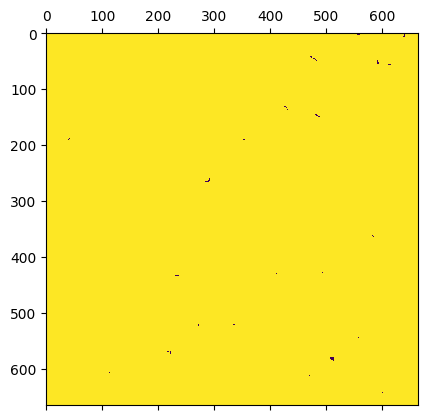

In [76]:
print(IMAGE_RAW.shape)
WATER = get_water_mask(IMAGE_RAW)
print(WATER.shape)
plt.matshow(WATER[0, :, :, 0])
# plot_all_bands(IMAGE_RAW, 0)

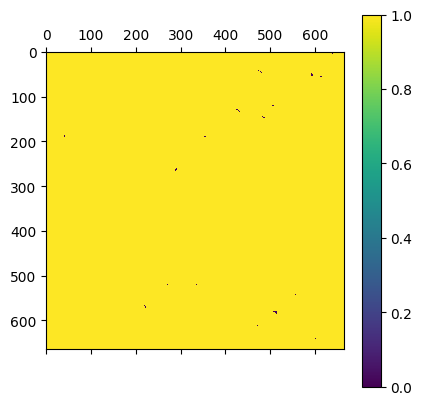

In [52]:
# for i in np.unique(IMAGE_RAW[0, :, :, -1]):
#     binary = bin(int(i))[2:]
#     print(binary[7], i)
    
img = np.where((IMAGE_RAW == 21888.0) | (IMAGE_RAW == 21952.0), 0, 1)
plt.matshow(img[0, :, :, -1])
plt.colorbar()

# Downprojection with UMAP

In [13]:
k_u_bands = []
k_u_band_label = []
for i in range(1, IMAGE.shape[1]-1):
    for j in range(1, IMAGE.shape[2]-1):
        k_u_bands.append(IMAGE[0, i-1:i+2, j-1:j+2, :].reshape(9*BANDS))
        k_u_band_label.append(LABELS[i, j])
bands = np.asarray(k_u_bands)
band_label = np.asarray(k_u_band_label)

index = np.random.choice(bands.shape[0], 3000, replace=False)  
data_pints_umap = bands[index]
labels_umap = band_label[index]

/home/mendozaemir/anaconda3/envs/remote-sensing-landuse/lib/python3.8/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


(3000, 2)


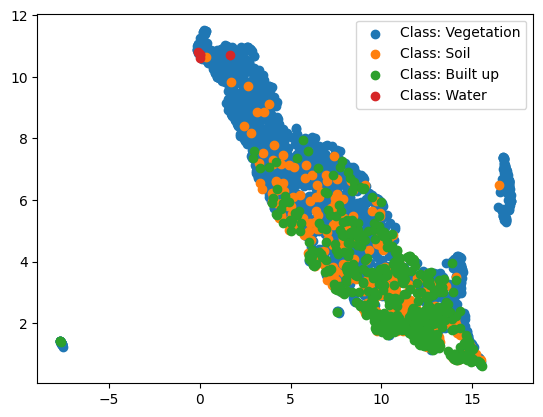

In [29]:
weight_matrix = np.asarray([
    [1.0, 1.0, 1.0],
    [1.0, 10.0, 1.0],
    [1.0, 1.0, 1.0]
])

weight_matrix = np.dstack([weight_matrix]*BANDS)

@numba.njit()
def sparse_eucliden_dist(a, b):
    a = a.reshape(3, 3, BANDS)
    b = b.reshape(3, 3, BANDS)
    dist = ((a-b)*weight_matrix).flatten()
    return np.linalg.norm((dist).flatten(), 1)




u = umap.UMAP(n_neighbors=10,
                min_dist=0.1,
                      metric=sparse_eucliden_dist).fit_transform(data_pints_umap)

print(u.shape)
def label_to_text(label):
    if label == 10:
        return "Vegetation"
    elif label == 40:
        return "Soil"
    elif label == 50:
        return "Built up"
    elif label == 80:
        return "Water"

for label in [10, 40, 50, 80]:
    label_idx = labels_umap == label
    plt.scatter(u[label_idx, 0], u[label_idx, 1], label=f"Class: {label_to_text(label)}")

plt.legend()
plt.show()

# Clustering with KMeans

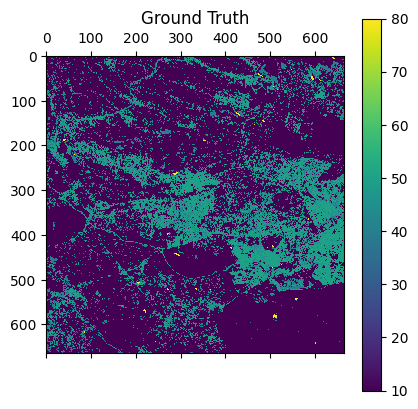

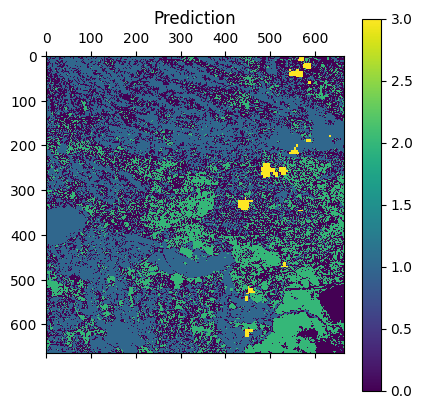

In [30]:
k_means_train = np.reshape(TRAIN_IMAGE[:, :, :, :], (TRAIN_IMAGE.shape[0]*TRAIN_IMAGE.shape[1]*TRAIN_IMAGE.shape[2], BANDS))
k_means_val   = IMAGE.reshape(IMAGE.shape[0]*IMAGE.shape[1]*IMAGE.shape[2], BANDS)

kmeans = KMeans(n_clusters=4).fit(k_means_train)
k_means_test_classification = kmeans.predict(k_means_val)
k_means_test_classification = k_means_test_classification.reshape((IMAGE.shape[1], IMAGE.shape[2]))

plt.matshow(LABELS)
plt.colorbar()
plt.title("Ground Truth")
plt.show()

plt.matshow(k_means_test_classification)
plt.title("Prediction")
plt.colorbar()
plt.show()

In [31]:
CLF_REMAP = {
    0: 50, # Water
    1: 10, # Builtup
    3: 80, # Soil
    2: 40, # Vegitation
}

for i in range(k_means_test_classification.shape[0]):
    for j in range(k_means_test_classification.shape[1]):
        k_means_test_classification[i, j] = CLF_REMAP[k_means_test_classification[i, j]]

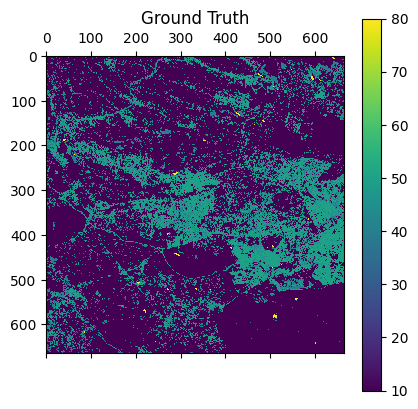

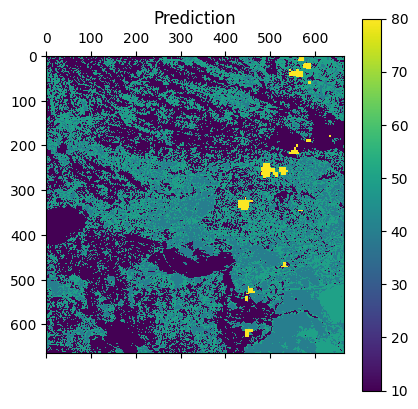

In [32]:
plt.matshow(LABELS)
plt.colorbar()
plt.title("Ground Truth")
plt.show()

plt.matshow(k_means_test_classification)
plt.title("Prediction")
plt.colorbar()
plt.show()

<AxesSubplot: title={'center': 'IIC'}>

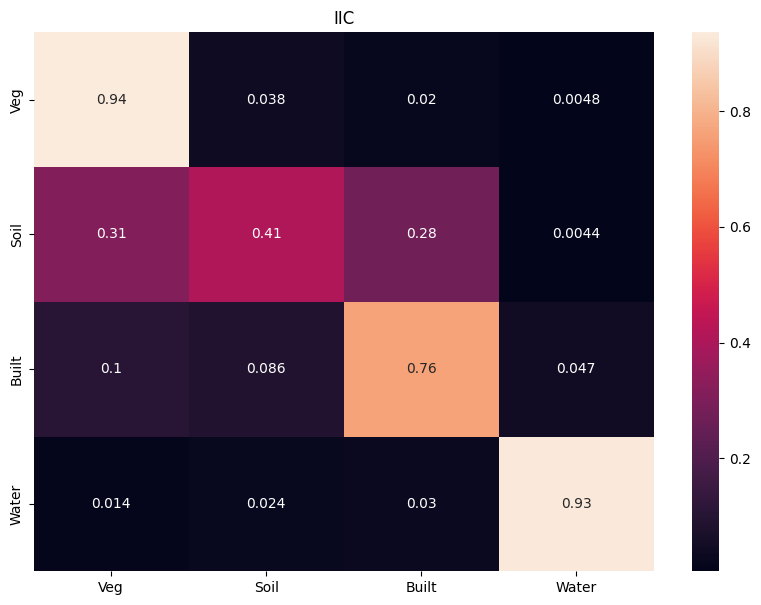

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cm = confusion_matrix(k_means_test_classification.flatten(), LABELS.flatten(), labels=[10, 40, 50, 80],  normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in ["Veg", "Soil", "Built", "Water", ]],
                  columns = [i for i in ["Veg", "Soil", "Built", "Water",]])
plt.figure(figsize = (10,7))
plt.title("IIC")
sn.heatmap(df_cm, annot=True)

# Clustering using IIC

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([7688, 10, 16, 16]) torch.Size([961, 10, 16, 16])
(10, 496, 496)


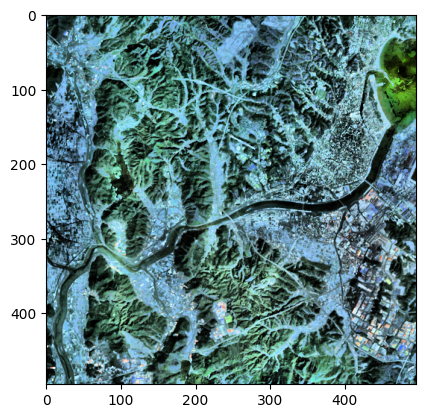

In [53]:
from iic.datasets import SateliteDataset
from iic.transforms import RandomVFlipTransformIIC, RandomHFlipTransformIIC
from iic.models import IICModel
from utils.data_preprocessing import segment_satelite_image, recombine_image



def create_image_dataset(image, sub_image_size):
    """
    Given a series of images: (Y, W, H, CH) create a dataset:
    (B, ch, sub_image, sub_imahe, )
    """
    ds = []
    recombination_size = None
    for year in range(image.shape[0]):
        img_ = image[0].transpose(2, 0, 1)
        seg_images, recombination_size_ = segment_satelite_image(img_, sub_size=sub_image_size)
        
        recombination_size = recombination_size_
        ground_truth = img_[:, :recombination_size[0]*sub_image_size, :recombination_size[1]*sub_image_size]
        assert np.allclose(ground_truth, recombine_image(seg_images, recombination_size_, sub_image_size).numpy())
        assert recombination_size is None or recombination_size_ == recombination_size
        
        ds.append(seg_images)
    return torch.concat(ds), recombination_size

SUB_IMAGE_SIZE = 16
CROP_FACTOR = 1.0


TRAIN_DATA, RECOMBINATION_SIZE = create_image_dataset(TRAIN_IMAGE, SUB_IMAGE_SIZE)
VALIDATION_DATA, _ = create_image_dataset(IMAGE, SUB_IMAGE_SIZE)
print(TRAIN_DATA.shape, VALIDATION_DATA.shape)

validation_rec = recombine_image(VALIDATION_DATA, RECOMBINATION_SIZE, SUB_IMAGE_SIZE).numpy()
print(validation_rec.shape)
plt.imshow(validation_rec[0:3].transpose((1, 2, 0)))
plt.show()

In [54]:
train_set = SateliteDataset(TRAIN_DATA, invariant_transforms=[RandomVFlipTransformIIC(0.5), RandomHFlipTransformIIC(0.5)])
val_set = SateliteDataset(VALIDATION_DATA, invariant_transforms=[])

train_size = int(len(train_set)*0.9)
val_size = len(train_set) - train_size
print(train_set[0:1]["img1"].shape)
print(train_set[0:1]["img2"].shape)
print(len(train_set), len(val_set))

torch.Size([1, 10, 16, 16])
torch.Size([1, 10, 16, 16])
7688 961


In [59]:
model = IICModel(BANDS, 4, int(SUB_IMAGE_SIZE*CROP_FACTOR))
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, num_workers=2)


trainer = pl.Trainer(max_epochs=10, devices=1)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type     | Params
----------------------------------
0 | net  | VGGTrunk | 21.1 K
----------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TODO tune hyperparams on big device

(31, 31)
(496, 496)
(496, 496)


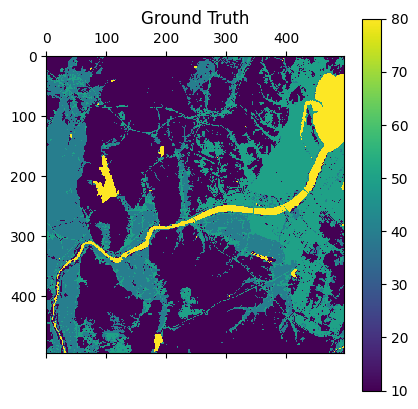

Traceback (most recent call last):
  File "/Users/davidwinderl/miniconda/envs/remote-sensing-landuse/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/davidwinderl/miniconda/envs/remote-sensing-landuse/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/davidwinderl/miniconda/envs/remote-sensing-landuse/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/davidwinderl/miniconda/envs/remote-sensing-landuse/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/davidwinderl/miniconda/envs/remote-sensing-landuse/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/Users/davidwinderl/miniconda/envs/remote-sensing-landuse/lib/python3.8/multiprocess

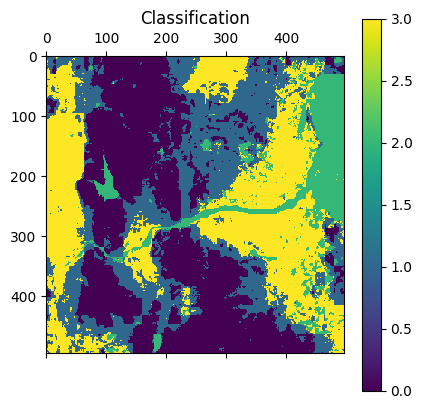

In [62]:
model = model.cpu()

SEG_IMAGE_OUT, RECOMBINATION_SIZE_OUT = segment_satelite_image(IMAGE, sub_size=int(SUB_IMAGE_SIZE*CROP_FACTOR))
print(RECOMBINATION_SIZE_OUT)
#VALIDATION_SET
sample_clf = model(val_set[0:]["img1"]).detach()
#sample_clf = model(SEG_IMAGE_OUT).detach()
sample_clf = recombine_image(sample_clf, RECOMBINATION_SIZE_OUT, int(SUB_IMAGE_SIZE*CROP_FACTOR))

test_classification = torch.argmax(sample_clf, axis=0).detach().numpy()

ground_truth_label = LABELS[:RECOMBINATION_SIZE_OUT[0]*int(SUB_IMAGE_SIZE*CROP_FACTOR), :RECOMBINATION_SIZE_OUT[1]*int(SUB_IMAGE_SIZE*CROP_FACTOR)]
print(ground_truth_label.shape)
print(test_classification.shape)

plt.matshow(ground_truth_label)
plt.colorbar()
plt.title("Ground Truth")
plt.show()

plt.matshow(test_classification)
plt.colorbar()
plt.title("Classification")
plt.show()